In [13]:
# Do not modify import block, all necessary imports are included
# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
%matplotlib inline

# This is for our hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster

# For our k-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from sklearn import datasets
import random

# for plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# this is for density plotting
from matplotlib import colorbar, colors
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
# import gsw
import math

# for the polygon intersections
import shapely.geometry as sg

# for plotting
import time
import warnings
warnings.filterwarnings('ignore')

#import "/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/gsw"
import sys
 
# appending a path
# sys.path.append('/scratch/project_2000789/muramarg/miniconda3/lib/python3.10/site-packages/')
 
# importing required module
import gsw

from scipy.interpolate import interpn

# load the datasets

In [2]:
filename = "/scratch/mmurakami/WAOM/categorized.nc"
ds = xr.load_dataset(filename)
ds1 = "/scratch/mmurakami/WAOM/drifter_data_all_withdepth.nc"
ds1 = xr.load_dataset(ds1)

In [33]:
temp = ds1.temp.values[:70000]
salt = ds1.salt.values[:70000]
dens = ds1.rho.values[:70000]

In [34]:
wmt = ds.categorized[:70000]

In [35]:
# convert the absolute salinity from practical salinity
# dSA = SA[-1]-SA[0]
dSA = salt[-1]-salt[0]
dCT = temp[-1]-temp[0]
drho_pot = dens[-1]-dens[0]


df = pd.DataFrame()
df["dT"] = dCT
df["dsat"] = dSA
df["drho"] = drho_pot
df

,dT,dsat,drho
0,0.759190,0.516079,1.396225
1,0.194226,0.128059,0.438326
2,0.931234,0.270897,0.774986
3,0.972425,-0.045643,1.597635
4,1.284990,0.206776,1.686916
...,...,...,...
3890,-2.295761,0.710316,9.257263
3891,-2.491627,0.262501,1.152145
3892,-0.378615,-0.154255,0.197741
3893,0.916063,0.058155,0.230589


[ 967 3743 3346 2947]
whats up
Cluster 0:
745
Cluster 1:
2468
Cluster 2:
323
Cluster 3:
359


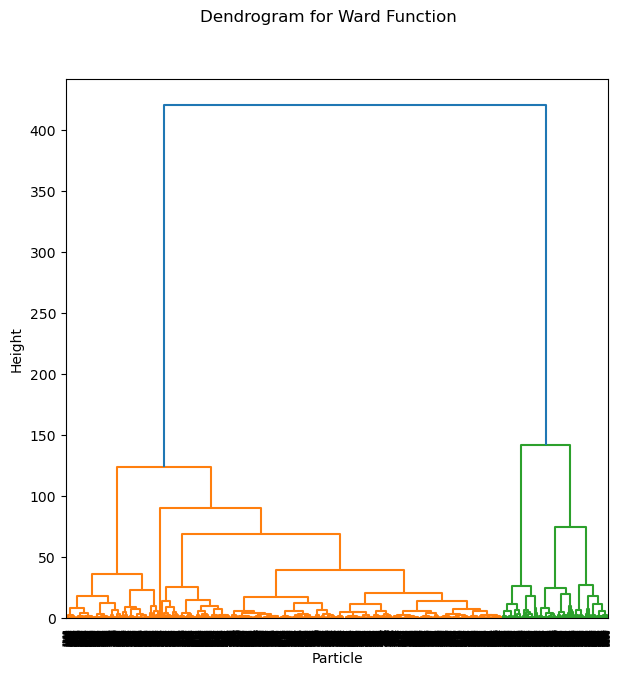

In [36]:
# Plot the dendrogram for the Ward proximity measure
index_names = list(df.index)
z = linkage(df,method='ward')
plt.figure(figsize = (7,7))
plt.suptitle('Dendrogram for Ward Function')
plt.xlabel('Particle')
plt.ylabel('Height')
dendrogramward = dendrogram(Z=z,labels=index_names,get_leaves=True)

# set the number of clusters and get the names
numclust = 4  # this was 6
fl = fcluster(z,numclust,criterion='maxclust')
# new dataframe
df_clst = pd.DataFrame()
df_clst['index']  = index_names
df_clst['clust_label']  = fl
# get the clusters from fcluster to choose centroids
centroids_idx = np.array([],dtype=int)
# for i in range(6):
for i in range(4):
    # print the values in each group
    elements = df_clst[df_clst['clust_label']==i+1]['index'].tolist()  
    size = len(elements)    
    # get a random number from elements as a centroid
    centroids_idx = np.append(centroids_idx, random.choice(elements))
print(centroids_idx)

# get the initial centroids
index_names = list(df.index)
c0 = df.iloc[index_names.index(centroids_idx[0])]
c1 = df.iloc[index_names.index(centroids_idx[1])]
c2 = df.iloc[index_names.index(centroids_idx[2])]
c3 = df.iloc[index_names.index(centroids_idx[3])]
# c4 = df.iloc[index_names.index(centroids_idx[4])]
# c5 = df.iloc[index_names.index(centroids_idx[5])]

centroids = np.array([c0,c1,c2,c3]) #,c4,c5])

# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=4,init=centroids,n_init=1,random_state=23).fit(df)
centroids = kmeans.cluster_centers_
assignment = kmeans.fit_predict(df,centroids)

# get the cluster for each state
zeroes=[x for x,y in enumerate(assignment) if y == 0]
ones=[x for x,y in enumerate(assignment) if y == 1]
twos=[x for x,y in enumerate(assignment) if y == 2]
threes=[x for x,y in enumerate(assignment) if y == 3]
# fours=[x for x,y in enumerate(assignment) if y == 4]
# fives=[x for x,y in enumerate(assignment) if y == 5]

clusters = [zeroes,ones,twos,threes]  #,fours,fives]
states = [[],[],[],[]] #,[],[]]
num = 0
print("whats up")
for clust in clusters:
    for idx in clust:
        state = index_names[idx]
        states[num].append(state)
    print('Cluster '+str(num)+':')
    print(len(states[num]))
    num += 1

In [37]:
# # get the indices for each of the groups
group1 = states[0]
group2 = states[1]
group3 = states[2]
group4 = states[3]
# group5 = states[4]
# group6 = states[5]
groups = np.array([group1,group2,group3,group4],dtype=object)   #,group5,group6

In [38]:
# quality of the grouping
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
WW_percents = np.array([])
other_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    #thismass = wmt_1[group]  # or wmt_1
    thismass = wmt[0][group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is msw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            WW_percents = np.append(WW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            other_percents = np.append(other_percents,counts_elements[i])

In [39]:
wmt_df = pd.DataFrame() #,"5","6"])
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["mSW"] = other_percents

# rename the indices
# wmt_df = wmt_df.reindex(["1","2","4","2"])

# remake the above dataframe with percentages
df1 = pd.DataFrame()# index=["1","2","3","4"])
df1["% of Total"] = wmt_df["# of particles"]/sum(wmt_df["# of particles"])
df1["AABW"] = wmt_df["AABW"]/wmt_df["# of particles"]
df1["mCDW"] = wmt_df["MCDW"]/wmt_df["# of particles"]
df1["ISW"] = wmt_df["ISW"]/wmt_df["# of particles"]
df1["DSW"] = wmt_df["DSW"]/wmt_df["# of particles"]
df1["AASW"] = wmt_df["AASW"]/wmt_df["# of particles"]
df1["WW"] = wmt_df["WW"]/wmt_df["# of particles"]
df1["mSW"] = wmt_df["mSW"]/wmt_df["# of particles"]

# df1 = df1.reindex(["3","1","6","2","4","5"])

df1.style.format({
    '% of Total': '{:,.2%}'.format,
    'AABW': '{:,.2%}'.format,
    'mCDW': '{:,.2%}'.format,
    'ISW' : '{:,.2%}'.format,
    'DSW' : '{:,.2%}'.format,
    'AASW': '{:,.2%}'.format,
    'WW'  : '{:,.2%}'.format,
    'mSW' : '{:,.2%}'.format
})

,% of Total,AABW,mCDW,ISW,DSW,AASW,WW,mSW
0,19.13%,0.00%,36.24%,0.54%,19.46%,27.92%,10.34%,5.50%
1,63.36%,0.00%,27.15%,0.20%,13.45%,42.79%,13.05%,3.36%
2,8.29%,0.00%,35.60%,0.00%,20.12%,26.32%,11.15%,6.81%
3,9.22%,0.00%,31.48%,0.56%,20.61%,32.59%,9.19%,5.57%


In [40]:
# quality of the grouping
# find the number of values in each group that match each of the water masses
# we have the arrays temp, freez_temp, salt, enddens_allvals, depth
lengths = np.array([])
AABW_percents = np.array([])
MCDW_percents = np.array([])
ISW_percents = np.array([])
DSW_percents = np.array([])
AASW_percents = np.array([])
WW_percents = np.array([])
other_percents = np.array([])

for group in groups:
    # how many particles are in the group
    lengths = np.append(lengths,len(group))
    
    # get the individual quantities of each group from mass and do value counts
    #thismass = wmt_1[group]  # or wmt_1
    thismass = wmt[-1][group]
    unique_elements, counts_elements = np.unique(thismass, return_counts=True)
    
    # see if any number is not in list and if not then add 0 to the end of the list
    for i in range(7):
        if not np.any(unique_elements == i):
            # append this number and zero to unique,counts
            unique_elements = np.append(unique_elements,i)
            counts_elements = np.append(counts_elements,0)
            
    # 0 is aabw, 1 is mcdw, 2 is isw, 3 is dsw, 4 is aasw, 5 is other (ISW shallower than 100m), 6 is msw
    
    for i in range(len(unique_elements)):
        if unique_elements[i] == 0:
            AABW_percents =np.append(AABW_percents,counts_elements[i])
        elif unique_elements[i] == 1:
            MCDW_percents =np.append(MCDW_percents,counts_elements[i])
        elif unique_elements[i] == 2:
            ISW_percents =np.append(ISW_percents,counts_elements[i])
        elif unique_elements[i] == 3:
            DSW_percents =np.append(DSW_percents,counts_elements[i])
        elif unique_elements[i] == 4:
            AASW_percents =np.append(AASW_percents,counts_elements[i])
        elif unique_elements[i] == 5:
            WW_percents = np.append(WW_percents,counts_elements[i])
        elif unique_elements[i] == 6:
            other_percents = np.append(other_percents,counts_elements[i])

In [41]:
wmt_df = pd.DataFrame() #,"5","6"])
wmt_df["# of particles"] = lengths
wmt_df["AABW"] = AABW_percents
wmt_df["MCDW"] = MCDW_percents
wmt_df["ISW"] = ISW_percents
wmt_df["DSW"] = DSW_percents
wmt_df["AASW"] = AASW_percents
wmt_df["WW"] = WW_percents
wmt_df["mSW"] = other_percents

# rename the indices
# wmt_df = wmt_df.reindex(["1","2","4","2"])

# remake the above dataframe with percentages
df1 = pd.DataFrame()# index=["1","2","3","4"])
df1["% of Total"] = wmt_df["# of particles"]/sum(wmt_df["# of particles"])
df1["AABW"] = wmt_df["AABW"]/wmt_df["# of particles"]
df1["mCDW"] = wmt_df["MCDW"]/wmt_df["# of particles"]
df1["ISW"] = wmt_df["ISW"]/wmt_df["# of particles"]
df1["DSW"] = wmt_df["DSW"]/wmt_df["# of particles"]
df1["AASW"] = wmt_df["AASW"]/wmt_df["# of particles"]
df1["WW"] = wmt_df["WW"]/wmt_df["# of particles"]
df1["mSW"] = wmt_df["mSW"]/wmt_df["# of particles"]

# df1 = df1.reindex(["3","1","6","2","4","5"])

df1.style.format({
    '% of Total': '{:,.2%}'.format,
    'AABW': '{:,.2%}'.format,
    'mCDW': '{:,.2%}'.format,
    'ISW' : '{:,.2%}'.format,
    'DSW' : '{:,.2%}'.format,
    'AASW': '{:,.2%}'.format,
    'WW'  : '{:,.2%}'.format,
    'mSW' : '{:,.2%}'.format
})

,% of Total,AABW,mCDW,ISW,DSW,AASW,WW,mSW
0,19.13%,33.02%,57.72%,7.38%,0.00%,0.81%,0.00%,1.07%
1,63.36%,0.00%,28.32%,2.39%,0.53%,53.85%,14.87%,0.04%
2,8.29%,100.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
3,9.22%,99.44%,0.28%,0.28%,0.00%,0.00%,0.00%,0.00%


# yes, this worked, now we can recreate the next set

In [42]:
# we have new_locs.txt
# we know there were 40664 originally released

In [43]:
new_locs = np.loadtxt('/scratch/mmurakami/WAOM/new_locs.txt', dtype=int)
Xgrid = ds1.Xgrid
Ygrid = ds1.Ygrid
valid_mask = ~np.isnan(Xgrid)

# Find indices of the first non-NaN values
first_non_nan_indices = np.where(valid_mask.any(axis=0), valid_mask.argmax(axis=0), -1)
xfirst = np.array([])
yfirst = np.array([])
for i in range(len(first_non_nan_indices)):
    if i%1000==0:
        print(i)
    xfirst = np.append(xfirst,Xgrid[first_non_nan_indices[i],i])
    yfirst = np.append(yfirst,Ygrid[first_non_nan_indices[i],i])

0
1000
2000
3000


In [46]:
points = np.column_stack((xfirst, yfirst))

# Get unique rows
unique_points = np.unique(points, axis=0)

print(unique_points.shape)

(181, 2)


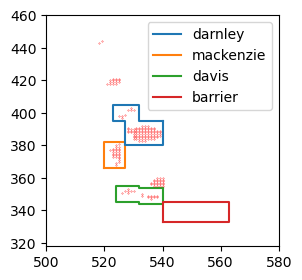

In [47]:
from shapely.ops import unary_union


# make an array of 6586 based on the starting polynya
fig = plt.figure(figsize=(3,3))
# ds1.h.isel().plot()
plt.plot(unique_points[:,0],unique_points[:,1],'.',markersize=0.5, color='r',zorder=5)
# plt.plot(xfirst,yfirst,'.',color="blue",markersize=0.5,marker='o')

plt.xlim(500,580)
plt.ylim(318,460)

# darnley
s = np.array([527,540,540,527,527])
t = np.array([380,380,395,395,380])
b = np.array([[a,b] for a,b in zip(s,t)])
s = np.array([523,532,532,523,523])
t = np.array([395,395,405,405,395])
c = np.array([[a,b] for a,b in zip(s,t)])
c = sg.Polygon(c)
darnley = sg.Polygon(b)
darnley = unary_union([c,darnley])

# mackenzie
s = np.array([520,527,527,520,520])
t = np.array([366,366,382,382,366])
b = np.array([[a,b] for a,b in zip(s,t)])
mackenzie = sg.Polygon(b)

# davis
s = np.array([524,532,532,524,524])
t = np.array([345,345,355,355,345])
b = np.array([[a,b] for a,b in zip(s,t)])
s = np.array([532,540,540,532,532])
t = np.array([344,344,354,354,344])
c = np.array([[a,b] for a,b in zip(s,t)])
c = sg.Polygon(c)
davis = sg.Polygon(b)
davis = unary_union([c,davis])

# mackenzie
s = np.array([540,563,563,540,540])
t = np.array([333,333,345,345,333])
b = np.array([[a,b] for a,b in zip(s,t)])
barrier = sg.Polygon(b)

# plot them
x, y = darnley.exterior.xy
plt.plot(x, y,label="darnley",zorder=5)

x,y = mackenzie.exterior.xy
plt.plot(x,y,label="mackenzie")

x,y = davis.exterior.xy
plt.plot(x,y,label="davis")

x,y = barrier.exterior.xy
plt.plot(x,y,label="barrier")
plt.legend()